# Yash Pandey - yp342
---


# CS383 Assignment 2


In [51]:
import math
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
import pandas as pd
import random
import numpy as np
from matplotlib import pyplot as plt

In [52]:
pd.set_option("display.max_columns", None)
PATH_TO_SPAMBASE = "spambase.data"
SEED = 0
random.seed(SEED)
ITERATION_CAP = pow(10, 4)
LGR_SPAM_ITER_CAP = 15 * pow(10,2)
PERCENT_CHANGE_CAP = pow(2, -23)
LEARN_RATE = pow(10, -2)

In [53]:
def get_iris_df():
    iris = datasets.load_iris()
    x = iris.data[:, :2]
    y = (iris.target != 0) * 1
    df_data = pd.DataFrame(data = x)
    df_target = pd.DataFrame(data = y)
    return df_data, df_target

def standardize_sr(sr, avg, std):
    sr_standardized = sr.apply(lambda x: ((x - avg) / std))
    return sr_standardized

def standardize_df(df):
    df = df.copy()
    for column_name in df.columns:
        sr = df[column_name]
        df[column_name] = standardize_sr(sr, sr.mean(), sr.std())
    return df

def generate_initial_random_theta(feature_count):
    mat_l = []
    for _ in range(0, feature_count + 1):
        mat_l.append(random.uniform(-1.0, 1.0))
    return np.matrix(mat_l).transpose()

def add_bias_feature(df):
    df = df.copy()
    ones_l = [1 for i in range(len(df))]
    df.insert(0, 'bias', value = ones_l)
    return df

def g_matrix_apply(x, theta):
    matrix_product = np.dot(x, theta)
    df = pd.DataFrame(matrix_product)
    res = df[0].apply(lambda i: 1/(1 + (math.e ** -i)))
    return np.matrix(res).transpose()

def probability(x, theta):
    return 1 - g_matrix_apply(x, theta)

def apply_natural_log_on_mat(mat):
    sr_mat = pd.DataFrame(mat).T[0]
    res = sr_mat.apply(lambda i: math.log(i))
    res = np.matrix(res)
    return res

def loss_calc(g_value, y_value):
    if 1 - g_value == 0:
        loss_val = -(y_value * math.log(g_value))
    else:
        loss_val = - ((y_value * math.log(g_value)) + ((1 - y_value) * math.log(1 - g_value)))
    return loss_val

def loss(g, y):
    iter_cap = len(y)
    net_loss = 0.0
    for row_num in range(iter_cap):
        g_v = g[row_num]
        y_v = y[row_num]
        calc_loss = loss_calc(g_v, y_v)
        net_loss += float(calc_loss)
    res = net_loss / iter_cap
    return res

def adjust_theta(theta_m, g_m, x_m, y_m):
    a = g_m - y_m
    b = np.dot(x_m.transpose(), a)
    const = LEARN_RATE/len(x_m)
    c = const * b
    res = theta_m - c
    return res

def plot_graph(x, y):
    lgr = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 10000)
    lgr.fit(x, y)

    minimum_x, maximum_x = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    minimum_y, maximum_y = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    step_size = 0.02  # step size in the mesh
    x_axis, y_axis = np.meshgrid(np.arange(minimum_x, maximum_x, step_size), np.arange(minimum_y, maximum_y, step_size))

    # Makes a color plot
    Z = lgr.predict(np.c_[x_axis.ravel(), y_axis.ravel()])
    Z = Z.reshape(x_axis.shape)
    plt.figure(1, figsize=(12, 9))
    plt.pcolormesh(x_axis, y_axis, Z, cmap=plt.cm.YlGn)

    # Plot also the training points
    plt.scatter(x[:, 0], x[:, 1], c = y, edgecolors="face", cmap=plt.cm.Pastel2)
    plt.xlabel("Sepal Length")
    plt.ylabel("Sepal Width")

    plt.xlim(x_axis.min(), x_axis.max())
    plt.ylim(y_axis.min(), y_axis.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [54]:
df_iris_data, df_iris_target = get_iris_df()
df_spambase = pd.read_csv(PATH_TO_SPAMBASE, header = None)

---
## Logistic Regression

In [55]:
# Logistic Regression
df_iris_data_std = standardize_df(df_iris_data)
df_features = add_bias_feature(df_iris_data_std)
x_matrix = np.matrix(df_features)
y_matrix = np.matrix(df_iris_target)
cur_loss = 0
g = None
theta_matrix = generate_initial_random_theta(len(df_iris_data_std.columns))
for iter_count in range(0, ITERATION_CAP):
    g = g_matrix_apply(x_matrix, theta_matrix)
    # prob = probability(x_matrix, theta_matrix)
    loss_value = loss(g, y_matrix)
    if abs(loss_value - cur_loss) < PERCENT_CHANGE_CAP:
        break
    cur_loss = loss_value
    theta_matrix = adjust_theta(theta_m = theta_matrix, g_m = g, x_m = x_matrix, y_m = y_matrix)
    print(f"{iter_count}: {loss_value}", end='\r')
    break

In [56]:
df_g = pd.DataFrame(g)
sr_g_boundary = df_g[0].copy()
sr_g_boundary = np.where(df_g[0] >= 0.5, 1, 0).T

### Plot of Original Feature and Classified Target

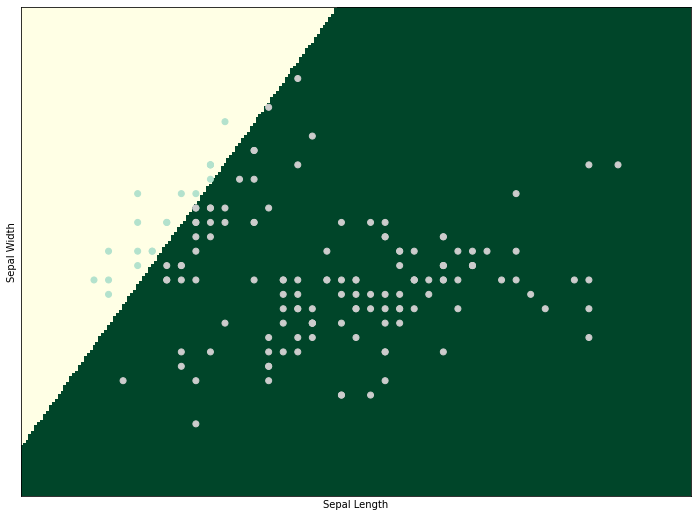

In [57]:
plot_graph(df_iris_data.to_numpy(), sr_g_boundary)

### Plot of Original Feature and Original Target

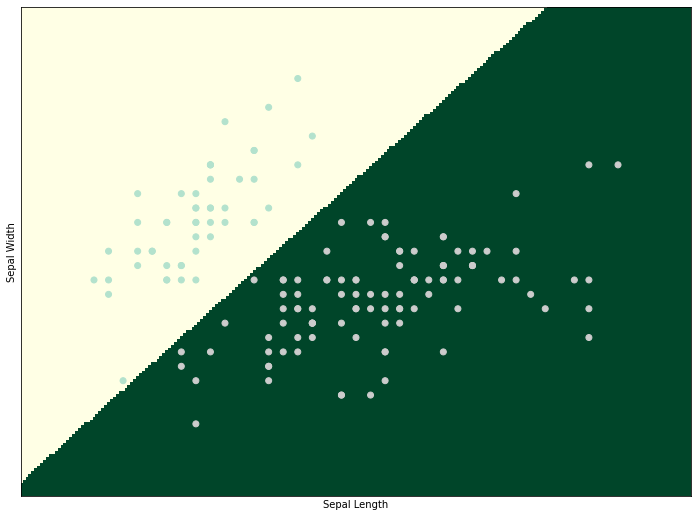

In [58]:
plot_graph(df_iris_data.to_numpy(), df_iris_target.to_numpy().ravel())

---
## Logistic Regression Spam Classification

In [59]:
def randomize_sr(sr):
    sr_array = sr.array
    random.shuffle(sr_array)
    return pd.Series(sr_array)

def get_shuffled_indices(df):
    i = df.index.tolist()
    random.shuffle(i)
    return i

def split_df_to_training_testing(df, fraction):
    length = int(math.ceil(len(df) * fraction))
    return df.iloc[:length], df.iloc[length:]

def add_bias_column(df):
    sr_bias = pd.Series([1 for i in range(len(df))])
    df_copy = df.copy()
    df_copy.insert(0, 'bias', sr_bias)
    df_copy = df_copy.T.reset_index(drop = True).T
    return df_copy

def separate_data_target(df, target_col_num):
    col_num = df.columns[target_col_num]
    df_copy = df.copy()    
    df_target = df_copy[col_num]
    df_copy.drop(col_num, axis = 1, inplace = True)
    return pd.DataFrame(df_copy), pd.DataFrame(df_target)

def standardize_sr(sr, avg, std):
    sr_standardized = sr.apply(lambda x: ((x - avg) / std))
    return sr_standardized

def standardize_train_data(df):
    df_copy = df.copy()
    df_std = df_copy.apply(lambda x: standardize_sr(x, x.mean(), x.std()))
    df_std[0].fillna(1, inplace=True)
    return pd.DataFrame(df_std)

def standardize_test_data(df, df_train):
    df_copy = df.copy()
    df_std = df_copy.apply(lambda x: standardize_sr(x, df_train[x.name].mean(), df_train[x.name].std()))
    df_std[0].fillna(1, inplace=True)
    return pd.DataFrame(df_std)

def calculate_target(df_x, t):
    res_l = []
    for _, row in df_x.iterrows():
        res = np.matrix(row) * t
        res_l.append(float(res))
    return pd.DataFrame(res_l)

def calculate_se(actual, target):
    error = float(actual) - float(target)
    sqr = error * error
    return sqr

def calculate_rmse_from_df(df_y, df_target):
    se_sum = 0
    for (_, y), (_, target) in zip(df_y.iterrows(), df_target.iterrows()):
        diff = calculate_se(y, target)
        se_sum += diff
    mse = se_sum/len(df_y)
    rmse = math.sqrt(mse)
    return rmse

def calculate_gradient(x_mat, y_mat, t):
    a = np.matmul(x_mat, t)
    b = a - y_mat
    grad = 2 * np.matmul(x_mat.transpose(), b)
    return grad

def hit_termination_criteria(cur, old, row_count):
    if (abs(cur - old) <= PERCENT_CHANGE_CAP) or (row_count >= LGR_SPAM_ITER_CAP):
        # print("Termination Criteria Met")
        return True
    else:
        return False

def error_type_classification(g, y):
    g_prob_arr = np.where(g >= 0.5, 1.0, 0.0)
    df_g = pd.DataFrame(g_prob_arr, columns = ['calculated'])
    df_y = pd.DataFrame(y, columns = ['actual'])
    df = df_g.join(df_y, how='outer')
    true_pos = 0    # true positive
    false_pos = 0   # false positive
    true_neg = 0    # true negative
    false_neg = 0   # false negative
    for _, value_pair in df.iterrows():
        g_v = value_pair.iloc[0]
        y_v = value_pair.iloc[1]
        if g_v == 1 and y_v == 1:
            true_pos += 1
        elif g_v == 0 and y_v == 0:
            true_neg += 1
        elif g_v == 1 and y_v == 0:
            false_pos += 1
        elif g_v == 0 and y_v == 1:
            false_neg += 1
    return true_pos, false_pos, true_neg, false_neg

def calculate_statistics(tp, fp, tn, fn):
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f = (2 * p * r) / (p + r)
    a = (tp + tn) / (tp + tn + fp + fn)
    return p, r, f, a

In [60]:
indices = get_shuffled_indices(df_spambase)
df_random = df_spambase.iloc[indices].copy().reset_index(drop = True)
df_random = add_bias_column(df_random)
df_train, df_test = split_df_to_training_testing(df_random, 2/3)
df_train_data, df_train_target = separate_data_target(df_train, -1)
df_test_data, df_test_target = separate_data_target(df_test, -1)
df_train_data_std = standardize_train_data(df_train_data)
df_test_data_std = standardize_test_data(df_test_data, df_train_data)
theta_matrix = generate_initial_random_theta(len(df_train_data_std.columns) - 1)
train_data_matrix = np.matrix(df_train_data_std)
train_target_matrix = np.matrix(df_train_target)
test_data_matrix = np.matrix(df_test_data_std)
test_target_matrix = np.matrix(df_test_target)
init_target = calculate_target(df_train_data_std, theta_matrix)
old_rmse = calculate_rmse_from_df(df_train_target, init_target)
cur_theta = theta_matrix.copy()
iter_count = 0
trainrmse_l = []
testrmse_l = []
g_matrix = None
cur_loss = 0
for row_num in range(0, LGR_SPAM_ITER_CAP):
    g_matrix = g_matrix_apply(train_data_matrix, theta_matrix)
    loss_value = loss(g_matrix, train_target_matrix)
    if hit_termination_criteria(cur_loss, loss_value, row_num):
         break
    theta_matrix = adjust_theta(theta_m = theta_matrix, g_m = g_matrix, x_m = train_data_matrix, y_m = train_target_matrix)
    print(f"Iter num: {row_num}", end='\r')
#     break  ############################################################################################# COMMENT OUT BEFORE SUBMITTING
final_g_matrix = g_matrix_apply(test_data_matrix, theta_matrix)
t_pos, f_pos, t_neg, f_neg = error_type_classification(final_g_matrix, test_target_matrix)
precision, recall, f_measure, accuracy = calculate_statistics(t_pos, f_pos, t_neg, f_neg)
print(f"Precision: {precision}\nRecall: {recall}\nF-Measure: {f_measure}\nAccuracy: {accuracy}")

Precision: 0.8972602739726028
Recall: 0.8343949044585988
F-Measure: 0.8646864686468647
Accuracy: 0.8930202217873451


---
## Naive Bayes Classifier

In [61]:
def split_spam_and_not_spam(df_spam, df_target):
    bool_spam_keys = np.logical_and(df_target, True)
    df_spm = df_spam.loc[bool_spam_keys.values]
    df_n_spm = df_spam.loc[np.logical_not(bool_spam_keys).values]
    return df_spm, df_n_spm

In [62]:
def gaussian_normal(val, std, mean):
    CONST = 1 / (math.sqrt(2 * math.pi) * std)
    exponent = - (pow(val - mean, 2)/(2 * (std ** 2)))
    a = pow(math.e, exponent)
    prod = CONST * a
    return prod

In [63]:
def gaussian_distribution(df_s_mean_std, df_ns_mean_std, p_s, p_ns, df = df_test_data_std):
    spam_normal_value_l = []
    not_spam_normal_value_l = []
    for _, sr_row in df.iterrows():
        normal_s_val = p_s
        normal_ns_val = p_ns
        for col_num, data_point in sr_row.iteritems():
            cur_s_std = df_s_mean_std[col_num]['std']
            cur_s_mean = df_s_mean_std[col_num]['mean']
            normal_s_val *= gaussian_normal(data_point, cur_s_std, cur_s_mean)
            cur_ns_std = df_ns_mean_std[col_num]['std']
            cur_ns_mean = df_ns_mean_std[col_num]['mean']
            normal_ns_val *= gaussian_normal(data_point, cur_ns_std, cur_ns_mean)
        spam_normal_value_l.append(normal_s_val)                  
        not_spam_normal_value_l.append(normal_ns_val)
    return pd.DataFrame([spam_normal_value_l, not_spam_normal_value_l], index = ['spam', 'not spam']).T


In [64]:
def product_of_every_column(df):
    prod_l = []
    for col in df.columns:
        tmp = df[col].product()
        prod_l.append(tmp)
    return prod_l

In [65]:
def get_probability(df_s, df_n_s):
    num_s = len(df_s)
    num_n_s = len(df_n_s)
    total_num_of_events = num_s + num_n_s
    prob_s = num_s / total_num_of_events
    prob_n_s = num_n_s / total_num_of_events
    return prob_s, prob_n_s

In [66]:
def true_false_classification(df_predicted_actual_pair):
    true_pos = 0    # true positive
    false_pos = 0   # false positive
    true_neg = 0    # true negative
    false_neg = 0   # false negative
    for _, value_pair in df_predicted_actual_pair.iterrows():
        g_v = value_pair.iloc[0]
        y_v = value_pair.iloc[1]
        if g_v == 1 and y_v == 1:
            true_pos += 1
        elif g_v == 0 and y_v == 0:
            true_neg += 1
        elif g_v == 1 and y_v == 0:
            false_pos += 1
        elif g_v == 0 and y_v == 1:
            false_neg += 1
    return true_pos, false_pos, true_neg, false_neg    

In [67]:
indices = get_shuffled_indices(df_spambase)
df_random = df_spambase.iloc[indices].copy().reset_index(drop = True)
df_train, df_test = split_df_to_training_testing(df_random, 2/3)

In [68]:
df_train_data, df_train_target = separate_data_target(df_train, -1)
df_test_data, df_test_target = separate_data_target(df_test, -1)

In [69]:
df_train_data_std = standardize_train_data(df_train_data)

In [70]:
df_test_data_std = standardize_test_data(df_test_data, df_train_data)

In [71]:
df_spam, df_not_spam = split_spam_and_not_spam(df_train_data_std, df_train_target)

In [72]:
df_spam_mean_std = pd.DataFrame([df_spam.mean(axis=0), df_spam.std()], index=['mean', 'std'])
df_not_spam_mean_std = pd.DataFrame([df_not_spam.mean(axis=0), df_not_spam.std()], index=['mean', 'std'])

In [73]:
prob_spam, prob_not_spam = get_probability(df_spam, df_not_spam)

In [74]:
df_val = gaussian_distribution(df_spam_mean_std, df_not_spam_mean_std, prob_spam, prob_not_spam, df_test_data_std)

In [75]:
df_val["prediction"] = np.where(df_val['spam']<df_val['not spam'], 1, 0)

In [76]:
df_prediction_target_pair = pd.DataFrame([df_val["prediction"], df_test_target[57].reset_index(drop=True)]).T

In [77]:
t_pos, f_pos, t_neg, f_neg = true_false_classification(df_prediction_target_pair)
precision, recall, f_measure, accuracy = calculate_statistics(t_pos, f_pos, t_neg, f_neg)
print(f"Precision: {precision}\nRecall: {recall}\nF-Measure: {f_measure}\nAccuracy: {accuracy}")

Precision: 0.04428571428571428
Recall: 0.050243111831442464
F-Measure: 0.047076689445709946
Accuracy: 0.18134377038486627
